# Transient circuit
![Circuit schematic](Transient_circuit.png){#fig-transient}

## Introduction
The circuit above is a filter designed to explore transient analysis of a circuit using Python. The dependent source, V1, will be a time varying signal described below.

## Circuit description
The circuit in @fig-transient is an elliptic low pass filter with a 1 Hz cut off and 3 dB of ripple in the pass band and 40 dB of attenuation in the stop band. Three dB of ripple in the pass band was designed in so that the transient response would have some ringing. The filter design tool linked [here](https://markimicrowave.com/technical-resources/tools/lc-filter-design-tool/) was used to design the filter.

## Circuit analysis
The circuit analysis follows the steps listed below.

- Draw circuit in LTSpice, export netlist
- Generate network equations
- Symbolic solution
- AC sweep and plot the frequency response at the output
- Transient analysis
  - Generate input signal for transient analysis
  - Mostly following the procedure outlined [here](https://stackoverflow.com/questions/77876224/calculating-inverse-laplace-transform-using-python-or-matlab)
  - display the results

Transient analysis is somewhat more involved than the other types of circuit analysis, primarily because SymPy's inverse Laplace transform is not very robust and can't handle complicated expressions. The output equation needs to be simplified by writing some code to put the equation into forms that SymPy can deal with. 

Load the following Python modules.

In [1]:
from sympy import *
import numpy as np
from tabulate import tabulate
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt
import SymMNA
from IPython.display import display, Markdown, Math, Latex
init_printing()

### Load the netlist
The netlist generated by LTSpice is pasted into the cell below and some edits were made to remove the inductor series resistance and the independent source, V1, is set to a value of one.

In [2]:
net_list = '''
V1 1 0 1
R1 3 1 1
R2 2 0 1
L1 3 4 0.4925
L2 5 0 0.05081
C2 4 5 0.09876
L3 4 2 0.4925
'''

Generate the network equations.

In [3]:
report, network_df, df2, A, X, Z = SymMNA.smna(net_list)

# Put matricies into SymPy 
X = Matrix(X)
Z = Matrix(Z)

NE_sym = Eq(A*X,Z)

Generate markdown text to display the network equations.

In [4]:
temp = ''
for i in range(len(X)):
    temp += '${:s}$<br>'.format(latex(Eq((A*X)[i:i+1][0],Z[i])))

Markdown(temp)

$I_{V1} + \frac{v_{1}}{R_{1}} - \frac{v_{3}}{R_{1}} = 0$<br>$- I_{L3} + \frac{v_{2}}{R_{2}} = 0$<br>$I_{L1} - \frac{v_{1}}{R_{1}} + \frac{v_{3}}{R_{1}} = 0$<br>$C_{2} s v_{4} - C_{2} s v_{5} - I_{L1} + I_{L3} = 0$<br>$- C_{2} s v_{4} + C_{2} s v_{5} + I_{L2} = 0$<br>$v_{1} = V_{1}$<br>$- I_{L1} L_{1} s + v_{3} - v_{4} = 0$<br>$- I_{L2} L_{2} s + v_{5} = 0$<br>$- I_{L3} L_{3} s - v_{2} + v_{4} = 0$<br>

As shown above MNA generated many equations and these would be difficult to solve by hand. The equations are displade in matrix notation below.

In [5]:
NE_sym

⎡               v₁   v₃         ⎤       
⎢        I_V1 + ── - ──         ⎥       
⎢               R₁   R₁         ⎥       
⎢                               ⎥   ⎡0 ⎤
⎢                  v₂           ⎥   ⎢  ⎥
⎢          -I_L3 + ──           ⎥   ⎢0 ⎥
⎢                  R₂           ⎥   ⎢  ⎥
⎢                               ⎥   ⎢0 ⎥
⎢               v₁   v₃         ⎥   ⎢  ⎥
⎢        I_L1 - ── + ──         ⎥   ⎢0 ⎥
⎢               R₁   R₁         ⎥   ⎢  ⎥
⎢                               ⎥ = ⎢0 ⎥
⎢C₂⋅s⋅v₄ - C₂⋅s⋅v₅ - I_L1 + I_L3⎥   ⎢  ⎥
⎢                               ⎥   ⎢V₁⎥
⎢   -C₂⋅s⋅v₄ + C₂⋅s⋅v₅ + I_L2   ⎥   ⎢  ⎥
⎢                               ⎥   ⎢0 ⎥
⎢              v₁               ⎥   ⎢  ⎥
⎢                               ⎥   ⎢0 ⎥
⎢     -I_L1⋅L₁⋅s + v₃ - v₄      ⎥   ⎢  ⎥
⎢                               ⎥   ⎣0 ⎦
⎢        -I_L2⋅L₂⋅s + v₅        ⎥       
⎢                               ⎥       
⎣     -I_L3⋅L₃⋅s - v₂ + v₄      ⎦       

The sysmbols generated by the Python code are extraced by the SymPy function free_symbols and then declared as SymPy variables. 

In [6]:
# turn the free symbols into SymPy variables
var(str(NE_sym.free_symbols).replace('{','').replace('}',''))

Built a dictionary of element values.

In [7]:
element_values = SymMNA.get_part_values(network_df)
element_values

## Symbolic solution
Since the circuit is not too large, a symbolic solution can be easily obtained.

In [8]:
U_sym = solve(NE_sym,X)

Display the symbolic solution

In [9]:
temp = ''
for i in U_sym.keys():
    temp += '${:s} = {:s}$<br>'.format(latex(i),latex(U_sym[i]))

Markdown(temp)

$v_{1} = V_{1}$<br>$v_{2} = \frac{C_{2} L_{2} R_{2} V_{1} s^{2} + R_{2} V_{1}}{C_{2} L_{1} L_{2} s^{3} + C_{2} L_{1} L_{3} s^{3} + C_{2} L_{1} R_{2} s^{2} + C_{2} L_{2} L_{3} s^{3} + C_{2} L_{2} R_{1} s^{2} + C_{2} L_{2} R_{2} s^{2} + C_{2} L_{3} R_{1} s^{2} + C_{2} R_{1} R_{2} s + L_{1} s + L_{3} s + R_{1} + R_{2}}$<br>$v_{3} = \frac{C_{2} L_{1} L_{2} V_{1} s^{3} + C_{2} L_{1} L_{3} V_{1} s^{3} + C_{2} L_{1} R_{2} V_{1} s^{2} + C_{2} L_{2} L_{3} V_{1} s^{3} + C_{2} L_{2} R_{2} V_{1} s^{2} + L_{1} V_{1} s + L_{3} V_{1} s + R_{2} V_{1}}{C_{2} L_{1} L_{2} s^{3} + C_{2} L_{1} L_{3} s^{3} + C_{2} L_{1} R_{2} s^{2} + C_{2} L_{2} L_{3} s^{3} + C_{2} L_{2} R_{1} s^{2} + C_{2} L_{2} R_{2} s^{2} + C_{2} L_{3} R_{1} s^{2} + C_{2} R_{1} R_{2} s + L_{1} s + L_{3} s + R_{1} + R_{2}}$<br>$v_{4} = \frac{C_{2} L_{2} L_{3} V_{1} s^{3} + C_{2} L_{2} R_{2} V_{1} s^{2} + L_{3} V_{1} s + R_{2} V_{1}}{C_{2} L_{1} L_{2} s^{3} + C_{2} L_{1} L_{3} s^{3} + C_{2} L_{1} R_{2} s^{2} + C_{2} L_{2} L_{3} s^{3} + C_{2} L_{2} R_{1} s^{2} + C_{2} L_{2} R_{2} s^{2} + C_{2} L_{3} R_{1} s^{2} + C_{2} R_{1} R_{2} s + L_{1} s + L_{3} s + R_{1} + R_{2}}$<br>$v_{5} = \frac{C_{2} L_{2} L_{3} V_{1} s^{3} + C_{2} L_{2} R_{2} V_{1} s^{2}}{C_{2} L_{1} L_{2} s^{3} + C_{2} L_{1} L_{3} s^{3} + C_{2} L_{1} R_{2} s^{2} + C_{2} L_{2} L_{3} s^{3} + C_{2} L_{2} R_{1} s^{2} + C_{2} L_{2} R_{2} s^{2} + C_{2} L_{3} R_{1} s^{2} + C_{2} R_{1} R_{2} s + L_{1} s + L_{3} s + R_{1} + R_{2}}$<br>$I_{V1} = \frac{- C_{2} L_{2} V_{1} s^{2} - C_{2} L_{3} V_{1} s^{2} - C_{2} R_{2} V_{1} s - V_{1}}{C_{2} L_{1} L_{2} s^{3} + C_{2} L_{1} L_{3} s^{3} + C_{2} L_{1} R_{2} s^{2} + C_{2} L_{2} L_{3} s^{3} + C_{2} L_{2} R_{1} s^{2} + C_{2} L_{2} R_{2} s^{2} + C_{2} L_{3} R_{1} s^{2} + C_{2} R_{1} R_{2} s + L_{1} s + L_{3} s + R_{1} + R_{2}}$<br>$I_{L1} = \frac{C_{2} L_{2} V_{1} s^{2} + C_{2} L_{3} V_{1} s^{2} + C_{2} R_{2} V_{1} s + V_{1}}{C_{2} L_{1} L_{2} s^{3} + C_{2} L_{1} L_{3} s^{3} + C_{2} L_{1} R_{2} s^{2} + C_{2} L_{2} L_{3} s^{3} + C_{2} L_{2} R_{1} s^{2} + C_{2} L_{2} R_{2} s^{2} + C_{2} L_{3} R_{1} s^{2} + C_{2} R_{1} R_{2} s + L_{1} s + L_{3} s + R_{1} + R_{2}}$<br>$I_{L2} = \frac{C_{2} L_{3} V_{1} s^{2} + C_{2} R_{2} V_{1} s}{C_{2} L_{1} L_{2} s^{3} + C_{2} L_{1} L_{3} s^{3} + C_{2} L_{1} R_{2} s^{2} + C_{2} L_{2} L_{3} s^{3} + C_{2} L_{2} R_{1} s^{2} + C_{2} L_{2} R_{2} s^{2} + C_{2} L_{3} R_{1} s^{2} + C_{2} R_{1} R_{2} s + L_{1} s + L_{3} s + R_{1} + R_{2}}$<br>$I_{L3} = \frac{C_{2} L_{2} V_{1} s^{2} + V_{1}}{C_{2} L_{1} L_{2} s^{3} + C_{2} L_{1} L_{3} s^{3} + C_{2} L_{1} R_{2} s^{2} + C_{2} L_{2} L_{3} s^{3} + C_{2} L_{2} R_{1} s^{2} + C_{2} L_{2} R_{2} s^{2} + C_{2} L_{3} R_{1} s^{2} + C_{2} R_{1} R_{2} s + L_{1} s + L_{3} s + R_{1} + R_{2}}$<br>

### AC Sweep
After substituting the numeric component values for the elements, a numerical solution for the note voltages can be obtained.

In [10]:
NE = NE_sym.subs(element_values)
NE

⎡            I_V1 + 1.0⋅v₁ - v₃            ⎤   ⎡ 0 ⎤
⎢                                          ⎥   ⎢   ⎥
⎢              -I_L3 + 1.0⋅v₂              ⎥   ⎢ 0 ⎥
⎢                                          ⎥   ⎢   ⎥
⎢            I_L1 - v₁ + 1.0⋅v₃            ⎥   ⎢ 0 ⎥
⎢                                          ⎥   ⎢   ⎥
⎢-I_L1 + I_L3 + 0.09876⋅s⋅v₄ - 0.09876⋅s⋅v₅⎥   ⎢ 0 ⎥
⎢                                          ⎥   ⎢   ⎥
⎢    I_L2 - 0.09876⋅s⋅v₄ + 0.09876⋅s⋅v₅    ⎥ = ⎢ 0 ⎥
⎢                                          ⎥   ⎢   ⎥
⎢                    v₁                    ⎥   ⎢1.0⎥
⎢                                          ⎥   ⎢   ⎥
⎢         -0.4925⋅I_L1⋅s + v₃ - v₄         ⎥   ⎢ 0 ⎥
⎢                                          ⎥   ⎢   ⎥
⎢           -0.05081⋅I_L2⋅s + v₅           ⎥   ⎢ 0 ⎥
⎢                                          ⎥   ⎢   ⎥
⎣         -0.4925⋅I_L3⋅s - v₂ + v₄         ⎦   ⎣ 0 ⎦

In [11]:
U_ac = solve(NE,X)

### Plot the frequency response at node 2

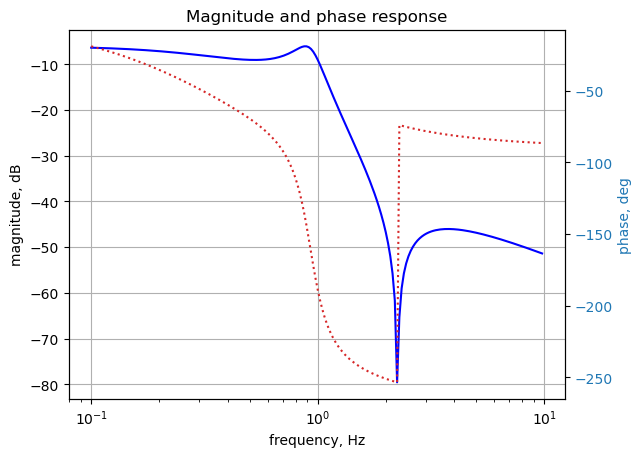

In [12]:
H = U_ac[v2]

num, denom = fraction(H) #returns numerator and denominator

# convert symbolic to numpy polynomial
a = np.array(Poly(num, s).all_coeffs(), dtype=float)
b = np.array(Poly(denom, s).all_coeffs(), dtype=float)
system = (a, b)

x = np.logspace(-1, 1, 200, endpoint=False)*2*np.pi
w, mag, phase = signal.bode(system, w=x) # returns: rad/s, mag in dB, phase in deg

fig, ax1 = plt.subplots()
ax1.set_ylabel('magnitude, dB')
ax1.set_xlabel('frequency, Hz')

plt.semilogx(w/(2*np.pi), mag,'-b')    # Bode magnitude plot

ax1.tick_params(axis='y')
#ax1.set_ylim((-30,20))
plt.grid()

# instantiate a second y-axes that shares the same x-axis
ax2 = ax1.twinx()
color = 'tab:blue'

plt.semilogx(w/(2*np.pi), phase,':',color='tab:red')  # Bode phase plot

ax2.set_ylabel('phase, deg',color=color)
ax2.tick_params(axis='y', labelcolor=color)
#ax2.set_ylim((-5,25))

plt.title('Magnitude and phase response')
plt.show()

### Low pass filter impulse and step response
Use the SciPy functions [impulse](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.impulse.html) and [step](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.step.html) to plot the impulse and step response of the system.

The [impulse](https://en.wikipedia.org/wiki/Impulse_response) and [step response](https://en.wikipedia.org/wiki/Step_response) of the filter are plotted below. Any linear, time-invariant is completely characterized by its impulse response. The transfer function is the Laplace transform of the impulse response. The impulse response defines the response of a linear time-invariant system for all frequencies.

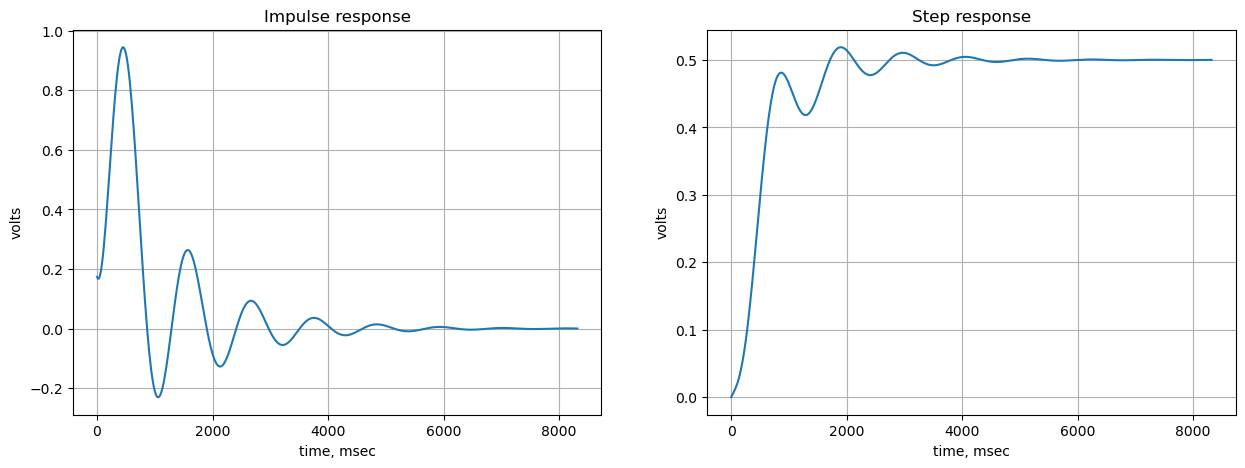

In [13]:
plt.subplots(1,2,figsize=(15, 5))

# using subplot function and creating
# plot one
plt.subplot(1, 2, 1)

# impulse response
t, y = signal.impulse(system,N=500)
plt.plot(t/1e-3, y)
plt.title('Impulse response')
plt.ylabel('volts')
plt.xlabel('time, msec')
plt.grid()

# using subplot function and creating plot two
plt.subplot(1, 2, 2)

t, y = signal.step(system,N=500)
plt.plot(t/1e-3, y)
plt.title('Step response')
plt.ylabel('volts')
plt.xlabel('time, msec')
plt.grid()

# show plot
plt.show()

The results obtained from SciPy's step2 function can be compared to the transient response results obtained below.

## Transient Analysis
The input signal for the filter circuit is defined by using SymPy's [Heaveside](https://docs.sympy.org/latest/modules/functions/special.html#sympy.functions.special.delta_functions.Heaviside) function. The signal has a positive step at t=0, followed by a return to zero amplitude at t=5.

Declare SymPy symbols needed during the analysis.

In [14]:
t = symbols('t',positive=True)  # t > 0

In [15]:
V1_t = 1*Heaviside(t)*(1-Heaviside(t-5))
V1_t

Use the [lambdify](https://docs.sympy.org/latest/modules/utilities/lambdify.html) function to convert the input signal to a function for plotting.

In [16]:
func_V1_t = lambdify(t, V1_t) 

The time domain description of the input signal is comvertered to the frequency domain with SymPy's [Laplace transform](https://docs.sympy.org/latest/modules/integrals/integrals.html#sympy.integrals.transforms.laplace_transform) function.

In [17]:
V1_s = laplace_transform(V1_t, t, s, noconds=True)
V1_s

Put the component values into the network equations and set V1 equal to the Laplace of the input signal.

In [18]:
element_values[V1] = V1_s
NE_trans = NE_sym.subs(element_values)
NE_trans

                                               ⎡    0    ⎤
                                               ⎢         ⎥
⎡            I_V1 + 1.0⋅v₁ - v₃            ⎤   ⎢    0    ⎥
⎢                                          ⎥   ⎢         ⎥
⎢              -I_L3 + 1.0⋅v₂              ⎥   ⎢    0    ⎥
⎢                                          ⎥   ⎢         ⎥
⎢            I_L1 - v₁ + 1.0⋅v₃            ⎥   ⎢    0    ⎥
⎢                                          ⎥   ⎢         ⎥
⎢-I_L1 + I_L3 + 0.09876⋅s⋅v₄ - 0.09876⋅s⋅v₅⎥   ⎢    0    ⎥
⎢                                          ⎥   ⎢         ⎥
⎢    I_L2 - 0.09876⋅s⋅v₄ + 0.09876⋅s⋅v₅    ⎥ = ⎢     -5⋅s⎥
⎢                                          ⎥   ⎢1   ℯ    ⎥
⎢                    v₁                    ⎥   ⎢─ - ─────⎥
⎢                                          ⎥   ⎢s     s  ⎥
⎢         -0.4925⋅I_L1⋅s + v₃ - v₄         ⎥   ⎢         ⎥
⎢                                          ⎥   ⎢    0    ⎥
⎢           -0.05081⋅I_L2⋅s + v₅           ⎥   ⎢        

Solve the newtork equations for the transient input and display the results.

In [19]:
U_trans = solve(NE_trans,X)

temp = ''
for i in U_trans.keys():
    temp += '${:s} = {:s}$<br>'.format(latex(i),latex(U_trans[i]))

Markdown(temp)

$v_{1} = \frac{1}{s} - \frac{e^{- 5.0 s}}{s}$<br>$v_{2} = \frac{1254498900.0 s^{2} e^{5.0 s}}{7224395229.0 s^{4} e^{5.0 s} + 26828647800.0 s^{3} e^{5.0 s} + 270940000000.0 s^{2} e^{5.0 s} + 500000000000.0 s e^{5.0 s}} - \frac{1254498900.0 s^{2}}{7224395229.0 s^{4} e^{5.0 s} + 26828647800.0 s^{3} e^{5.0 s} + 270940000000.0 s^{2} e^{5.0 s} + 500000000000.0 s e^{5.0 s}} + \frac{250000000000.0 e^{5.0 s}}{7224395229.0 s^{4} e^{5.0 s} + 26828647800.0 s^{3} e^{5.0 s} + 270940000000.0 s^{2} e^{5.0 s} + 500000000000.0 s e^{5.0 s}} - \frac{250000000000.0}{7224395229.0 s^{4} e^{5.0 s} + 26828647800.0 s^{3} e^{5.0 s} + 270940000000.0 s^{2} e^{5.0 s} + 500000000000.0 s e^{5.0 s}}$<br>$v_{3} = \frac{7224395229.0 s^{3} e^{5.0 s}}{7224395229.0 s^{4} e^{5.0 s} + 26828647800.0 s^{3} e^{5.0 s} + 270940000000.0 s^{2} e^{5.0 s} + 500000000000.0 s e^{5.0 s}} - \frac{7224395229.0 s^{3}}{7224395229.0 s^{4} e^{5.0 s} + 26828647800.0 s^{3} e^{5.0 s} + 270940000000.0 s^{2} e^{5.0 s} + 500000000000.0 s e^{5.0 s}} + \frac{13414323900.0 s^{2} e^{5.0 s}}{7224395229.0 s^{4} e^{5.0 s} + 26828647800.0 s^{3} e^{5.0 s} + 270940000000.0 s^{2} e^{5.0 s} + 500000000000.0 s e^{5.0 s}} - \frac{13414323900.0 s^{2}}{7224395229.0 s^{4} e^{5.0 s} + 26828647800.0 s^{3} e^{5.0 s} + 270940000000.0 s^{2} e^{5.0 s} + 500000000000.0 s e^{5.0 s}} + \frac{246250000000.0 s e^{5.0 s}}{7224395229.0 s^{4} e^{5.0 s} + 26828647800.0 s^{3} e^{5.0 s} + 270940000000.0 s^{2} e^{5.0 s} + 500000000000.0 s e^{5.0 s}} - \frac{246250000000.0 s}{7224395229.0 s^{4} e^{5.0 s} + 26828647800.0 s^{3} e^{5.0 s} + 270940000000.0 s^{2} e^{5.0 s} + 500000000000.0 s e^{5.0 s}} + \frac{250000000000.0 e^{5.0 s}}{7224395229.0 s^{4} e^{5.0 s} + 26828647800.0 s^{3} e^{5.0 s} + 270940000000.0 s^{2} e^{5.0 s} + 500000000000.0 s e^{5.0 s}} - \frac{250000000000.0}{7224395229.0 s^{4} e^{5.0 s} + 26828647800.0 s^{3} e^{5.0 s} + 270940000000.0 s^{2} e^{5.0 s} + 500000000000.0 s e^{5.0 s}}$<br>$v_{4} = \frac{12544989.0 s^{2} e^{5.0 s}}{146688228.0 s^{3} e^{5.0 s} + 246900000.0 s^{2} e^{5.0 s} + 5000000000.0 s e^{5.0 s}} - \frac{12544989.0 s^{2}}{146688228.0 s^{3} e^{5.0 s} + 246900000.0 s^{2} e^{5.0 s} + 5000000000.0 s e^{5.0 s}} + \frac{2500000000.0 e^{5.0 s}}{146688228.0 s^{3} e^{5.0 s} + 246900000.0 s^{2} e^{5.0 s} + 5000000000.0 s e^{5.0 s}} - \frac{2500000000.0}{146688228.0 s^{3} e^{5.0 s} + 246900000.0 s^{2} e^{5.0 s} + 5000000000.0 s e^{5.0 s}}$<br>$v_{5} = \frac{12544989.0 s e^{5.0 s}}{146688228.0 s^{2} e^{5.0 s} + 246900000.0 s e^{5.0 s} + 5000000000.0 e^{5.0 s}} - \frac{12544989.0 s}{146688228.0 s^{2} e^{5.0 s} + 246900000.0 s e^{5.0 s} + 5000000000.0 e^{5.0 s}}$<br>$I_{V1} = - \frac{13414323900.0 s^{2} e^{5.0 s}}{7224395229.0 s^{4} e^{5.0 s} + 26828647800.0 s^{3} e^{5.0 s} + 270940000000.0 s^{2} e^{5.0 s} + 500000000000.0 s e^{5.0 s}} + \frac{13414323900.0 s^{2}}{7224395229.0 s^{4} e^{5.0 s} + 26828647800.0 s^{3} e^{5.0 s} + 270940000000.0 s^{2} e^{5.0 s} + 500000000000.0 s e^{5.0 s}} - \frac{24690000000.0 s e^{5.0 s}}{7224395229.0 s^{4} e^{5.0 s} + 26828647800.0 s^{3} e^{5.0 s} + 270940000000.0 s^{2} e^{5.0 s} + 500000000000.0 s e^{5.0 s}} + \frac{24690000000.0 s}{7224395229.0 s^{4} e^{5.0 s} + 26828647800.0 s^{3} e^{5.0 s} + 270940000000.0 s^{2} e^{5.0 s} + 500000000000.0 s e^{5.0 s}} - \frac{250000000000.0 e^{5.0 s}}{7224395229.0 s^{4} e^{5.0 s} + 26828647800.0 s^{3} e^{5.0 s} + 270940000000.0 s^{2} e^{5.0 s} + 500000000000.0 s e^{5.0 s}} + \frac{250000000000.0}{7224395229.0 s^{4} e^{5.0 s} + 26828647800.0 s^{3} e^{5.0 s} + 270940000000.0 s^{2} e^{5.0 s} + 500000000000.0 s e^{5.0 s}}$<br>$I_{L1} = \frac{13414323900.0 s^{2} e^{5.0 s}}{7224395229.0 s^{4} e^{5.0 s} + 26828647800.0 s^{3} e^{5.0 s} + 270940000000.0 s^{2} e^{5.0 s} + 500000000000.0 s e^{5.0 s}} - \frac{13414323900.0 s^{2}}{7224395229.0 s^{4} e^{5.0 s} + 26828647800.0 s^{3} e^{5.0 s} + 270940000000.0 s^{2} e^{5.0 s} + 500000000000.0 s e^{5.0 s}} + \frac{24690000000.0 s e^{5.0 s}}{7224395229.0 s^{4} e^{5.0 s} + 26828647800.0 s^{3} e^{5.0 s} + 270940000000.0 s^{2} e^{5.0 s} + 500000000000.0 s e^{5.0 s}} - \frac{24690000000.0 s}{7224395229.0 s^{4} e^{5.0 s} + 26828647800.0 s^{3} e^{5.0 s} + 270940000000.0 s^{2} e^{5.0 s} + 500000000000.0 s e^{5.0 s}} + \frac{250000000000.0 e^{5.0 s}}{7224395229.0 s^{4} e^{5.0 s} + 26828647800.0 s^{3} e^{5.0 s} + 270940000000.0 s^{2} e^{5.0 s} + 500000000000.0 s e^{5.0 s}} - \frac{250000000000.0}{7224395229.0 s^{4} e^{5.0 s} + 26828647800.0 s^{3} e^{5.0 s} + 270940000000.0 s^{2} e^{5.0 s} + 500000000000.0 s e^{5.0 s}}$<br>$I_{L2} = \frac{61725000.0 e^{5.0 s}}{36672057.0 s^{2} e^{5.0 s} + 61725000.0 s e^{5.0 s} + 1250000000.0 e^{5.0 s}} - \frac{61725000.0}{36672057.0 s^{2} e^{5.0 s} + 61725000.0 s e^{5.0 s} + 1250000000.0 e^{5.0 s}}$<br>$I_{L3} = \frac{1254498900.0 s^{2} e^{5.0 s}}{7224395229.0 s^{4} e^{5.0 s} + 26828647800.0 s^{3} e^{5.0 s} + 270940000000.0 s^{2} e^{5.0 s} + 500000000000.0 s e^{5.0 s}} - \frac{1254498900.0 s^{2}}{7224395229.0 s^{4} e^{5.0 s} + 26828647800.0 s^{3} e^{5.0 s} + 270940000000.0 s^{2} e^{5.0 s} + 500000000000.0 s e^{5.0 s}} + \frac{250000000000.0 e^{5.0 s}}{7224395229.0 s^{4} e^{5.0 s} + 26828647800.0 s^{3} e^{5.0 s} + 270940000000.0 s^{2} e^{5.0 s} + 500000000000.0 s e^{5.0 s}} - \frac{250000000000.0}{7224395229.0 s^{4} e^{5.0 s} + 26828647800.0 s^{3} e^{5.0 s} + 270940000000.0 s^{2} e^{5.0 s} + 500000000000.0 s e^{5.0 s}}$<br>

The equations for the solution are complex and long, but are easy to obtain and display. 

The voltage on node 2 is the output of the filter. The expression is symplified with the chain of operators applied to the expression; [nsimplify()](https://docs.sympy.org/latest/modules/simplify/simplify.html#sympy.simplify.simplify.nsimplify), [simplify()](https://docs.sympy.org/latest/modules/simplify/simplify.html#simplify), [expand()](https://docs.sympy.org/latest/modules/core.html#sympy.core.function.expand) and [together()](https://docs.sympy.org/latest/modules/polys/reference.html#sympy.polys.rationaltools.together).

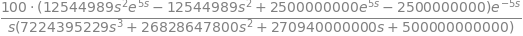

In [20]:
H = U_trans[v2].nsimplify().simplify().expand().together()
H

All the time dealy terms are in the numerator. 

Extract the numerator and denominator and display.

In [21]:
n, d = fraction(H)
display('numerator', n, 'denominator', d)

'numerator'

'denominator'

Each of the numerator terms can be put over the common denominator.

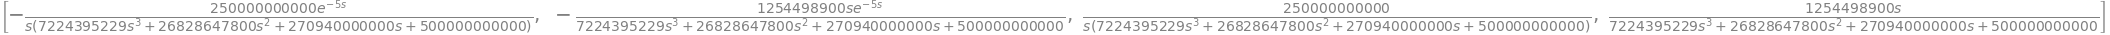

In [22]:
terms = [a / d for a in n.args]
display(terms)

The following code processes each of the terms obtained above. 

- The time delay operator $e^{-ts}$ is removed from the xpression and the value of the time delay is saved in a list.
- use the SciPy [residue](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.residue.html) function to get the partial-fraction expansion residues and poles
- build the partial expansion terms and find the inverse Laplace of each one and save

In [23]:
time_delay = []
delay = []
N = []

for i in terms:
    # look for and remove the time delay
    if len(i.find(exp)) == 1:
        delay = i.find(exp).pop()
        time_delay.append(list(delay.atoms())[0])
        ans = i/i.find(exp).pop()
    else:
        ans = i
        time_delay.append(0)

    # use the SciPy residue function to get the partial-fraction expansion residues and poles
    n, d = fraction(ans)
    cn = Poly(n, s).all_coeffs()
    cd = Poly(d, s).all_coeffs()
    r, p, k = signal.residue(cn, cd, tol=0.001, rtype='avg')
    
    # build a symbolic expression for each of the residues and find the inverse Laplace of each one and save
    z = 0
    for i in range(len(r)):
        m = (r[i]/(s-p[i])) #.nsimplify()
        z += inverse_laplace_transform(m, s, t)

    N.append(z)

The time delays associated with each term are:

In [24]:
time_delay

The time domain version of each of the terms is displayed below.

In [25]:
N

Each of these terms came be converted to a function using SymPy's [lambdify](https://docs.sympy.org/latest/modules/utilities/lambdify.html) function.

In [26]:
out0 = lambdify(t, N[0])
out1 = lambdify(t, N[1])
out2 = lambdify(t, N[2])
out3 = lambdify(t, N[3])

Define the values for the x-axis of the plot and put each one into an array for plotting.

In [27]:
x = np.linspace(0, 10, 2000, endpoint=True)

out0a = out0(x)
out1a = out1(x)
out2a = out2(x)
out3a = out3(x)

The arrays, out2a and out3a, do not have any delay so they can be summed and used to create the final array for plotting.

In [28]:
out = out2a + out3a

The arrays, out0a and out1a, have a delay associated with them, so and offset in the time is included by shifting right by the corrrect amount. 

In [29]:
offset = 1000
out[offset:] = out[offset:] + (out0a[0:-offset] + out1a[0:-offset])

Plot the final combined result.

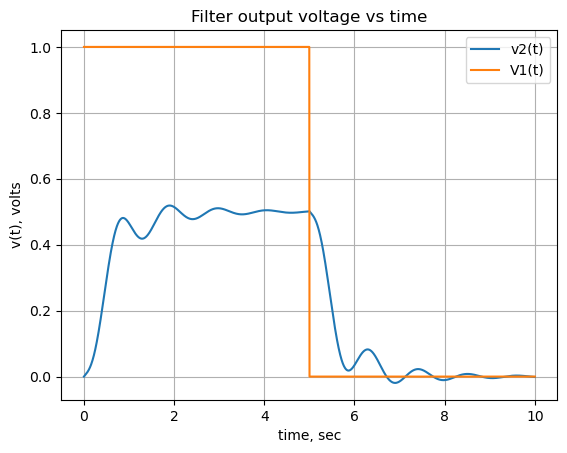

In [30]:
plt.title('Filter output voltage vs time')

plt.plot(x, np.real(out),label='v2(t)')
plt.plot(x, np.real(func_V1_t(x)),label='V1(t)')

plt.ylabel('v(t), volts')
plt.xlabel('time, sec')

plt.legend()
plt.grid()
plt.show()

## Summary
The inverse Laplace transform of complicated expressions requires that they be reduced to a set of simple terms by particial fraction expansion. I've not yet figured a way to easily code the delay terms, so these are handled manually by a offset shift in the finaly plot output.